In [1]:
###first let's load up the BAT LC and look at the data and file headers!


import numpy as np
import scipy.stats as st
from astropy.io import fits,ascii
from astropy.time import Time
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('font', family='serif')
import scipy as sp
import scipy.signal
import palettable
from scipy.optimize import curve_fit
%matplotlib inline



In [2]:
def loadlc(infile='SMCX-1.orbit.lc.fits', DoPlot=True):
    
    mydata=fits.open(infile)
    
    obs_time=mydata[1].data['MJD']
    
    obs_err=mydata[1].data['ERROR']
    
    obs_rate=mydata[1].data['RATE']

    
    
    ## want to filter the data based on error. For right now, let's just make it less than the mean error?
    
    err_filt=np.where(obs_err<(np.mean(obs_err)))
    
    #print (obs_time.shape, obs_time[err_filt].shape) #removes roughly 17% of the data points
    
    time=obs_time[err_filt]
    err=obs_err[err_filt]
    rate=obs_rate[err_filt]
    
    if DoPlot:
      
        plt.figure(figsize=(16,12))
        plt.errorbar(time, rate, yerr=err, fmt='o', alpha=0.5, color=palettable.cubehelix.cubehelix3_16.mpl_colors[10])
        plt.ylabel('Rate (ct/s)', fontsize=15)
        plt.xlabel('Time (MJD)', fontsize=15)
        plt.savefig('mylc.pdf')
        
    return time, rate, err

In [3]:
##step 2! split up the data (let's use n=25) and generate a LS

def splitdata(nSliver=100, DoPlot=True):
    my_time, my_rate, my_error=loadlc()
    
    ###copying and modifying from Will&Kristen's 2014 code:
    
    PeakPeriods = np.zeros(nSliver)
    PeakStDev = np.zeros(nSliver)
    StripTMeds = np.zeros(nSliver)
    tMin=np.min(my_time)
    tMax=np.max(my_time)
    DELTA = (tMax - tMin)/nSliver
    nMinPerStrip=50
    
    aPuffy = np.array([])
    
    
    for j in range(nSliver):
            MinStrip = tMin + j*DELTA
            MaxStrip = MinStrip + DELTA
            gStrip=np.where( (my_time >= MinStrip) & (my_time <=MaxStrip) )[0]

            if np.size(gStrip) < nMinPerStrip:
                print "INFO - too few points in this strip. Skipping."
                continue
            else:
                print "INFO - Working on time-strip %f-%f, %i points:" \
                    % (MinStrip, MaxStrip, np.size(gStrip))

            vTheseFreqs, vThesePowers, normval = LombScargle(my_time[gStrip], my_rate[gStrip])
            
            vThesePeriods = (2*np.pi)/vTheseFreqs
            
            
            if np.size(aPuffy) < 1:
                        aPuffy = np.copy(vThesePowers)
                        #need to add up tStart and tEnd for the dictionary
                        vTStarts = np.copy(MinStrip)
                        vTEnds = np.copy(MaxStrip)

            else:
                        aPuffy = np.vstack( (aPuffy, vThesePowers) )
                        vTStarts = np.vstack( (vTStarts, MinStrip) ) 
                        vTEnds = np.vstack( (vTEnds, MaxStrip) )

    print aPuffy.shape
    return aPuffy, vTStarts, vTEnds, vThesePeriods

In [10]:
def FindP_Sup(nSliver=60):
    
    powers, t_start, t_end, periods=splitdata(nSliver=nSliver)
    peaklist=np.array([])
    for j in range(nSliver): 
        newpeak=ReturnPeakPeriod(periods, powers[j])
        
        if np.size(peaklist) <1:
            peaklist=np.copy(newpeak)
        else:
            peaklist=np.vstack((peaklist, newpeak))
    
    print peaklist.shape
    tmed=t_end-t_start
    plt.figure(3)
    plt.figure(figsize=(8,6))
    plt.plot(t_med, peaklist)
    plt.xlabel('Time (MJD)')
    plt.ylabel('Superorbital Period (days)')
    plt.savefig('P_sup.pdf')

In [5]:
###Copying our old LS code--should be fine? --will modify later to switch to a LS that can include error bars on data points!
def LombScargle(x=np.array([]), y=np.array([]),lowf = 0.001, highf = 3, nout = 2000, DoLog=True, DoPlot=True):

    """wrapper for L-S periodogram"""


   # LombScargle(aData['TIME'][g], aData['RATE'][g])
  

   # TEST to see if we get out what we put in...
#    y_In = np.copy(y)
   
   # inject a sine-wave with smplitude 15 and period 60 days just to
   # ensure we're recovering what we think we are...

   # TEST to see if we get out what we put in...
   # y = y_In + 15.0*np.sin(x*2.0*np.pi/60.0)

    normval = x.shape[0]
    f = np.linspace(lowf,highf, nout)

    if not DoLog:
        f = np.linspace(lowf,highf, nout)
    else:
        f = np.logspace(np.log10(lowf), np.log10(highf), nout)
        # f = 1.0/f
        
        # Just for consistenty, show the results
        ### WIC - commented out: # print np.min(f), np.max(f)

    pgram = sp.signal.lombscargle(x, y, f)  

    # NOTE Wed Dec 18th 2013: there is an extra factor 2pi in the
    # definition of the frequency used by sp.signal.lombscargle! To
    # put the results into "days" or "per-days", divide the frequency
    # by 2pi after computing lombscargle. That fudge is done here:

    # WIC Mon Apr 14th - commented out this in-place modification,
    # which is dangerous!
#    f = f / (2.0*np.pi)

    # NOTE Fri March 14th - use the same normalization that pgram
    # uses:
#    pgram = np.sqrt(4*(pgram/normval))

    if not DoPlot:
        return f, pgram, normval

    print "INFO - plotting..."
    plt.figure(2)
    plt.clf()
    plt.subplot(2, 1, 1,)
    plt.plot(x, y, 'b+')
    
    # Use the same time range for hte plot. WARNING -- hardcoding!!
    #plt.xlim(50000,56000)

    plt.subplot(2, 1, 2,)
    plt.semilogx(2.0*np.pi/f, np.sqrt(4*(pgram/normval)))
#    plt.semilogx(1.0/f, np.sqrt(4*(pgram/normval)), 'r.' )
    
    plt.xlabel('Period (days)')
    plt.ylabel('log10(power)')

    # WIC Feb 17th 2014: Include syntax to add the minmax times to the
    # filename. Convert the times to integers to avoid long filenames!
    sXMin=str(np.int(np.min(x)))
    sXMax=str(np.int(np.max(x)))
    FileOut="SLIVER_Pgrams_%s-%s.png" % (sXMin, sXMax)  

    # WIC Feb 17th 2014: Have used "SLIVER" as the filename stem so that later on we
    # could remove them all by typing "rm SLIVER*png" at the
    # command-line or something similar, and this would not nuke all
    # the png files we've made thus far - only the slivers.

    # WIC Feb 17th 2014: note: the "blah_%s" % (value) is how we pass
    # string variables into another string variable (the filename).

    plt.savefig(FileOut)

    return f, pgram, normval

In [6]:
def Gauss(x, *P):
    return P[0]*np.exp(-(x-P[1])**2/(2.*P[2]**2))

def ReturnPeakPeriod(vThesePeriods, vThesePowers):
    gCands=np.where( (vThesePeriods < 70.0) & (vThesePeriods > 3.0) )[0]
    iStrongest = np.argmax(vThesePowers[gCands])
    #print iStrongest, "prrrrrint"
    FirstGuess = vThesePeriods[gCands[iStrongest]]
    
    print "DBG:: First guess:", FirstGuess

    # WIC Mon Apr 14th 10:30pm - hardcoded this a bit further to
    # really zoom in on that peak... Use all points within 20 days of
    # the period as our input trial-set
    gFocus = np.where(np.abs(vThesePeriods - FirstGuess) < 2.0)[0]

    vGuess = [vThesePowers[gCands[iStrongest]], FirstGuess, 5.0]
    coeff, var_matrix = curve_fit(Gauss, \
                                  vThesePeriods[gFocus], \
                                  vThesePowers[gFocus], p0=vGuess, \
                                  maxfev=200000)
    print FirstGuess, iStrongest, "printy printy print"
    Grause = Gauss(vThesePeriods, coeff[0], coeff[1], coeff[2])

    #plt.figure(8)
    #plt.clf()
    #plt.semilogx(vThesePeriods, vThesePowers, 'b-')
    #plt.plot(FirstGuess, iStrongest, 'm*')
    #plt.semilogx(vThesePeriods,  Grause, 'g-') 
    #plt.show()
    return coeff[1], FirstGuess, iStrongest

INFO - Working on time-strip 53416.000000-53501.000000, 1044 points:
INFO - plotting...
INFO - Working on time-strip 53501.000000-53586.000000, 331 points:
INFO - plotting...
INFO - Working on time-strip 53586.000000-53671.000000, 848 points:
INFO - plotting...
INFO - Working on time-strip 53671.000000-53756.000000, 455 points:
INFO - plotting...
INFO - Working on time-strip 53756.000000-53841.000000, 444 points:
INFO - plotting...
INFO - Working on time-strip 53841.000000-53926.000000, 598 points:
INFO - plotting...
INFO - Working on time-strip 53926.000000-54011.000000, 1517 points:
INFO - plotting...
INFO - Working on time-strip 54011.000000-54096.000000, 1550 points:
INFO - plotting...
INFO - Working on time-strip 54096.000000-54181.000000, 977 points:
INFO - plotting...
INFO - Working on time-strip 54181.000000-54266.000000, 930 points:
INFO - plotting...
INFO - Working on time-strip 54266.000000-54351.000000, 497 points:
INFO - plotting...
INFO - Working on time-strip 54351.00000

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 200000.

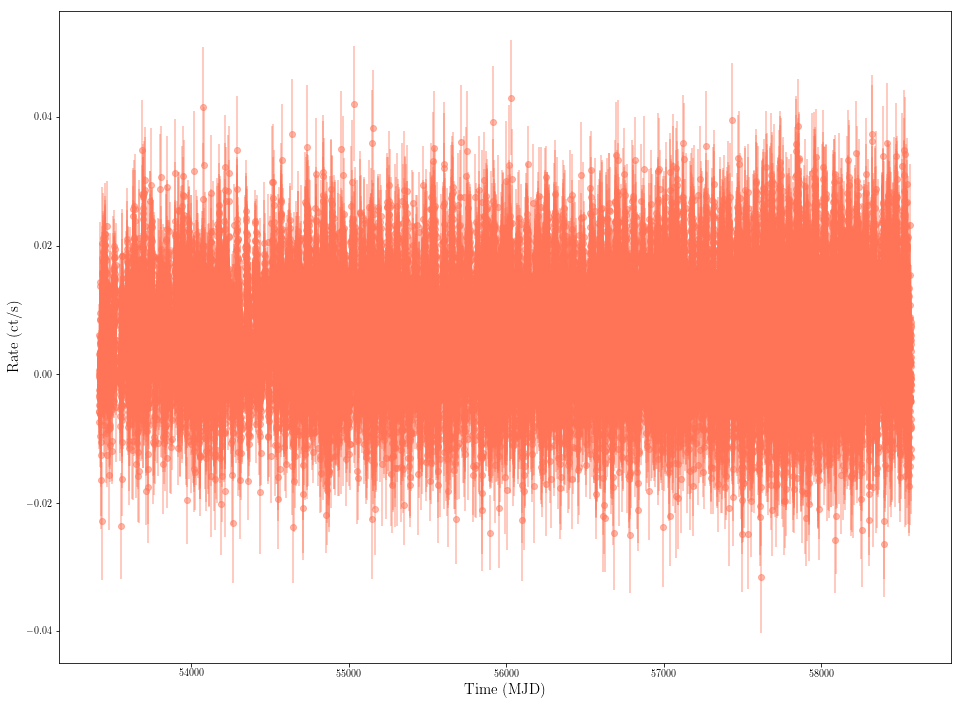

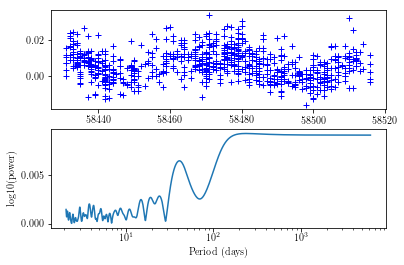

In [11]:
FindP_Sup()